In [2]:
import numpy as np

#Creating an array of size (5.3)
arr = np.random.rand(8)
one_hot = np.zeros((arr.shape[0],3))

for idx, val in enumerate(arr.astype(int)):
    one_hot[idx,val] = 1.0

print(arr,one_hot)

[5.60319164e-01 3.22653225e-01 5.66904104e-01 9.50095285e-01
 9.08942554e-04 5.58935499e-01 9.65594672e-01 3.43868151e-01] [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [8]:
idx = np.arange(60000)
print(idx)

for i in range(0, idx.shape[0] - 300 +1, 300):
    batch_size = idx[i:i+300]
    print(batch_size)

[    0     1     2 ... 59997 59998 59999]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 

# Image Classification MLP Model 

In [34]:
import numpy as np
import sys


class NeuralMetwork_fs:

    """
    Multi Layer preceptron classifier

    Parameters
    =========================

    n_hidden - int (default 30)
    Number of hidden units in nn

    l2- float (default 0.)
    Regularization lambda of the model
    by summing cost up to avoid overfitting (training model too close to train data)

    n_epochs - int (default 100)
    Number of times the model be trained

    eta- float (default 0.0001)
    Learning rate for the model

    minibatch_size- int (default 100)
    Batch size for each back propagation

    n_seed - int (default None)
    seed value

    Attributes
    ==========================

    eval_ : dict {cost, train_acc, val_acc}
    Dictionary to store cost, training accuracy and validation
    accurary over each epoch set

    Methods
    ===========================

    _onehot:
        Encodes label into one hot encoding
    -sigmoid:
        Compute logistic function
    -forward:
        Calculate the forward pass for the nn
    -ComputeCost:
        Cost calculation btw train and class labels.
    -predict:
        model to predit untrained data
    -fit:
        model to training over epoch set


    """

    def __init__(self, n_hidden=30, l2=0., epochs = 100, eta = 0.001,
                minibatch_size =1,shuffle=True,seed=None ):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.minibatch_size = minibatch_size
        self.shuffle = shuffle

    def _onehot(self,y, n_classes):
        '''
        Enables label into one hot encoding

        Parameter:
        ====================

        y: array [sample]
        array of data

        n_classes: int 
        number of true class label

        Return:
        =======================

        one hot: matrix [sample,n_classes]
        one hot encoding of samples in matrix
        size sample x n_classes

        '''
        #initializes the matrix with zeros of size [n_sample,n_classes]
        one_hot = np.zeros((y.shape[0],n_classes))

        #iterate over label vector y
        for idx, val in enumerate(y.astype(int)):
            one_hot[idx,val] = 1.

        return one_hot
    
    def _sigmoid(self, Z):
        '''
        Parameter:
        ====================

        Z: matrix [sample,hidden], [sample,class label]
        net input function 

        Return:
        =====================

        A_out: matrix [sample,hidden], [sample,class label]
        sigmoid activation over net input function

        '''

        return 1./ (1. + np.exp(-np.clip(Z, -250, 250)))
    
    def _forward(self, X):

        '''
        Computes forward propagation from input to activation of output layer

        Parameters:
        ======================
        X : [samples, features]
        train data set which has to be 
        fed to feed forward layer

        Return:
        Z_h : [samples, n_hidden]
        net input function of the hidden layer

        A_h : [samples, n_hidden]
        Activation function of hidden layer

        Z_out : [samples, n_classlabels]
        net input function of the output layer

        A_out : [samples, n_classlabels]
        Activation function of output layer

        '''
        #Step 1 - compute net input layer
        #   [samples,n_hidden]  =    [samples,n_features]  .  [n_features,n_hidden] 
        #        Z_h            =            X            dot        W_h
        Z_h   = np.dot(X,self.W_h) + self.B_h

        #Step 2 - Activating the hidden layer
        #  A_h =  phi(Z_h)
        #  [samples,n_hidden]  = sigmoid([samples,n_hidden])
        A_h  = self._sigmoid(Z_h)

        #Step 3 - compute net input function for output layer
        #   [samples,n_classlabels]  =    [samples,n_hidden]  dot  [n_hidden,n_classlabels] 
        #        Z_out            =            A_h            dot        W_out
        Z_out =  np.dot(A_h,self.W_out) + self.B_out


        #Step 4 - Activating the output layer
        #  A_out =  phi(Z_out)
        #  [samples,n_classlabels]  = sigmoid([samples,n_classlabels])
        A_out  = self._sigmoid(Z_out)

        return Z_h, A_h, Z_out, A_out
    
    def _computeCost(self,y_enc,output):
        '''
        To compute the logistic cost function on feed forward data

        Parameters:
        ======================

        y_enc: {array} [samples,n_classlabels]
        Represents one hot encoding of class labels

        output: {array} [samples,n_classlabels]
        Activation function of output layer

        Return:
        ======================

        cost: float
        Regularized cost

        '''

        #calculate the l2 term
        L2_regularization = (self.l2 * (np.sum(self.W_h**2) + np.sum(self.W_out**2)))

        #part1 calculate the cost for true value 1
        n_term = -y_enc * (np.log(output))

        #part1 calculate the cost for true value 1
        n_term2 = (1. - y_enc) * (np.log(1. - output))

        #calculate the cost
        cost = np.sum(n_term - n_term2) * L2_regularization

        return cost
    
    def _predict(self, X_val):
        '''
        Function to predict the new data set

        Parameters:
        =======================
        X_val: {array} [sample, n_feature]
        untrained data or new data sets given as input to the MLP model

        Return:
        ========================
        y_pred : {array}, shape = [n_samples]
        Predicted class labels

        '''
        #forward call
        Z_h, A_h, Z_out, A_out = self._forward(X_val)

        #predicting the max value from samples 
        y_pred = np.argmax(Z_out, axis = 1)

        return y_pred
    
    def _fit(self,X_train, y_train, X_valid, y_valid):
        """
        Fits model parameters (weights) to training data

        Parameters
        =====================
        X_train : {array}, shape = [n_samples, n_features]
            Feature matrix of training data
        y_train : {array}, shape = [n_samples]
           Label vector of training data
        X_valid : {array}, shape = [n_samples, n_features]
            Feature matrix of validation data
        y_valid : {array}, shape = [n_samples]
            Label vector of validation data

        Returns
        ===================
        None
        """
        #Get the number of unique class
        n_classlabels = np.unique(y_train).shape[0]

        #Get the number of features units
        n_features = X_train.shape[1]

        #######################
        #Weight initialization
        #######################

        #Get the weight input -> hidden
        self.B_h = np.zeros(self.n_hidden)
        self.W_h = self.random.normal(loc=0.0, scale=0.1, 
                                      size=(n_features, self.n_hidden))
        

        #Get the weight hidden -> output
        self.B_out = np.zeros(n_classlabels)
        self.W_out = self.random.normal(loc=0.0, scale=0.1, 
                                      size=(self.n_hidden,n_classlabels))

        # Length of string for formatting
        epoch_strlen = len(str(self.epochs))
        # Dictionary for documentation
        self.eval_ = {'cost':[], 'train_acc':[], 'valid_acc':[]}

        #one hot encoding
        y_train_enc = self._onehot(y_train, n_classlabels)

        #iterate over each epochs
        for i in range(self.epochs):

            # indices with equal interval over row dimension of X_train
            indices = np.arange(X_train.shape[0])

            #shuffle true
            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in  range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):

                batch_size = indices[start_idx:start_idx + self.minibatch_size]

                #forward propagation
                Z_h, A_h, Z_out, A_out = self._forward(X_train[batch_size])

                ##################
                # Backpropagation
                ##################

                ###################
                # Update of W_out

                #[sample,n_classlabels] = [sample,n_classlabels] - [sample,n_classlabels]
                delta_out = A_out - y_train_enc[batch_size]

                #[n_hidden, n_classlabels] = [n_hidden, sample] dot [sample,n_classlabels]
                nabla_W_out_1 = np.dot(A_h.T, delta_out)
                #[n_hidden, n_classlabels] = [n_hidden, n_classlabels]
                nabla_W_out_2 = self.l2 * self.W_out

                #[n_classlabels] = [sample,n_classlabels] 
                nabla_B_out = np.sum(delta_out, axis=0)

                #[n_hidden, n_classlabels]
                delta_W_out = (-1.) * self.eta * (nabla_W_out_1 + nabla_W_out_2)

                #[n_classlabels]
                delta_B_out = (-1.) * self.eta * nabla_B_out

                #update weights and bias
                self.W_out += delta_W_out
                self.B_out += delta_B_out


                ###################
                # Update of W_h

                #[sample, n_hidden]  =   [sample,n_classlabels]  dot  [n_classlabels, n_hidden]
                nabla_W_h_1 =  (np.dot(delta_out, self.W_out.T)) * (A_h *(1. - A_h))

                #[n_features, n_hidden]   =  [n_features, sample]  dot  [sample, n_hidden]
                nabla_W_h_2  = np.dot(X_train[batch_size].T, nabla_W_h_1)

                #[n_features, n_hidden]
                nabla_W_h_3 = self.l2 * self.W_h

                #[n_hidden]
                nabla_B_h  =  np.sum(nabla_W_h_1, axis=0)

                #[n_features, n_hidden]
                delta_W_h = -1. * self.eta * (nabla_W_h_2 + nabla_W_h_3)

                #[n_hidden]
                delta_B_h = -1. * self.eta * nabla_B_h

                #update W_h and B_h

                self.W_h += delta_W_h
                self.B_h += delta_B_h

            ##############
            #Evaluation
            ##############

            #Evaluation after each epochs
            Z_h, A_h, Z_out, A_out = self._forward(X_train)

            #Determine cost of update weight 
            cost = self._computeCost(y_enc = y_train_enc, output = A_out)

            #Determine training and validation accuracy 
            y_pred_train = self._predict(X_train)
            y_pred_valid = self._predict(X_valid)

            train_acc = ( (np.sum(y_train == y_pred_train)).astype(np.float64) / X_train.shape[0])

            valid_acc = ( (np.sum(y_valid == y_pred_valid)).astype(np.float64) / X_valid.shape[0])

            # Print basic information after each epoch
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            #stores cost and accuracy
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

# **Apply** NeuralMetwork_fs for **image recognition**

### To recognize **hand written digits**


In [35]:
import numpy as np

#Load data from numpy zip file
minst = np.load('mnist_scaled.npz')

minst.files

#unpack the data wrt to kwy words X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = [minst[f] for f in ['X_train', 'y_train', 'X_test', 'y_test']]

#clr memory
del minst

print(f"shape of X_train {X_train.shape}")
print(f"shape of y_train {y_train.shape}")
print(f"shape of X_test {X_test.shape}")
print(f"shape of y_test {y_test.shape}")


shape of X_train (60000, 784)
shape of y_train (60000,)
shape of X_test (10000, 784)
shape of y_test (10000,)


# **Run** NeuralNetwork_fs

### Instantiate the class and fit model

In [36]:
# call the neural network class
nn = NeuralMetwork_fs(n_hidden = 100,
                      l2 = 0.03,
                      epochs=100,
                      eta=0.0005,
                      minibatch_size=300,
                      shuffle=True,
                      seed=1) 

nn._fit(X_train=X_train[:55000],
        y_train= y_train[:55000],
        X_valid= X_train[55000:],
        y_valid= y_train[55000:])

100/100 | Cost: 376350.01 | Train/Valid Acc.: 98.38%/97.64%  

## Plot degression cost over epochs

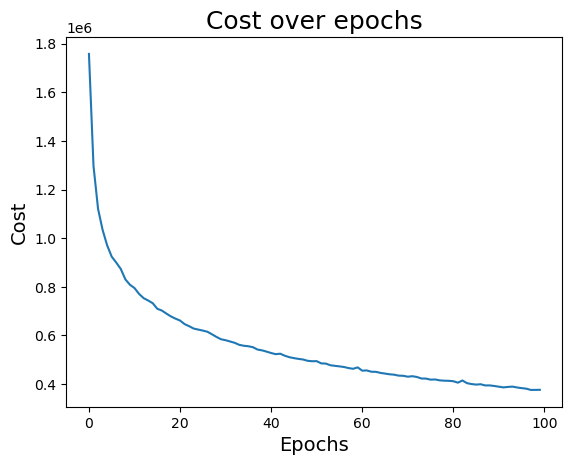

In [37]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.title("Cost over epochs", fontsize=18)
plt.show()

## Training accuracy vs validation accuracy

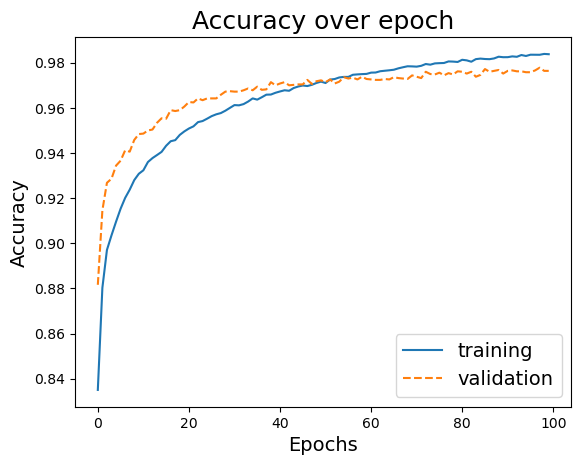

In [38]:
#plot training accuracy
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='training')

#plot validation accuracy
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation',
          linestyle='--')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title("Accuracy over epoch", fontsize=18)
plt.legend(loc='lower right', fontsize=14)
plt.show()


## Evaluate the accuracy with untrained data

In [39]:
#pass the untrained data
y_pred_test = nn._predict(X_test)

training_accuracy = ((np.sum(y_test == y_pred_test)).astype(np.float64)/
                     X_test.shape[0])

print(f'Training accuracy of predict model {training_accuracy * 100:0.2f}%')

Training accuracy of predict model 97.14%


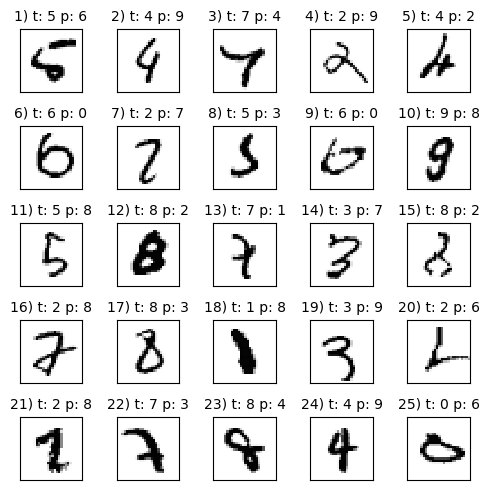

In [41]:
# Filter misclassified examples and select first 25
miscl_img = X_test[y_test != y_pred_test][:25]
correct_lab = y_test[y_test != y_pred_test][:25]
miscl_lab = y_pred_test[y_test != y_pred_test][:25]

# Arrange plot in 5 rows and 5 columns
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(5,5))
ax = ax.flatten()
# Plot misclassified pictures in loop
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' %(i+1, correct_lab[i], miscl_lab[i]),fontsize=10)

# Arrange canvas
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()